In [73]:
import numpy as np
from pf import pf   # the Python Package of Assessing Pfaffian (PPAP)

class tfim(object):
    def __init__(self,M): # each M gives quenched disorder Hamiltonian configuration, 
        # in case of disorder average, this object need to be constructed multiple times
        # with different Ms satisfying some distribution.
        self.M=M # M is an L by L matrix, contains all parameters of a chain
        self.L=M.shape[0]  # L is the length of 1 dimensional Ising chain
        
        self.u, self.s, self.vh = np.linalg.svd(M)
   
    def aux_matrix_dynamics_block_for_test(self,t):
        # this is for test purpose
        A1=np.zeros((self.L, self.L), dtype=complex)
        A2=A1+0
        A3=A1+0
        A4=A1+0
        for i in range(L):
            for j in range(L):
                A1[i,j]=(i+1)+(j+1)*1j
                A2[i,j]=(i+1)-(j+1)*1j
                A3[i,j]=-(i+1)+(j+1)*1j
                A4[i,j]=-(i+1)-(j+1)*1j
                
        for i in range(L):
            for j in range(L):
                A1[i,j]=1+t
                A2[i,j]=2+t
                A3[i,j]=3+t
                A4[i,j]=4+t

        
        
        A12=np.concatenate((A1, A2), axis=1)
        A34=np.concatenate((A3, A4), axis=1)
        return np.concatenate((A12,A34),axis=0)   # 这里之所以没有乘以2，参见“推导3”
        
    def aux_matrix_dynamics(self,t):
        W=np.diag(np.exp(-2.0*1j*t*self.s))
        
        A1=np.matmul(np.matmul(self.vh.transpose(), W), self.vh)
        A2=np.matmul(np.matmul(self.vh.transpose(), W), self.u.transpose())
        A3=np.matmul(np.matmul(self.u, W), self.vh)
        A4=np.matmul(np.matmul(self.u, W), self.u.transpose())
        
        
        A12=np.concatenate((A1, A2), axis=1)
        A34=np.concatenate((A3, A4), axis=1)
        return np.concatenate((A12,-A34),axis=0)   # 这里之所以没有乘以2，参见“推导3”
        
    def aux_matrix_dynamics_badone(self,t):
        M_zeros=np.zeros((self.L, self.L))
        M_ones=np.identity(self.L)
        M_P=np.diag(np.exp(2.0*1j*t*self.s))
        
        A1=np.concatenate((self.vh.transpose(), M_zeros), axis=1)
        A2=np.concatenate((M_zeros,self.u), axis=1)
        M1=np.concatenate((A1,A2),axis=0)
        
        A3=np.concatenate((M_P, -M_P), axis=1)
        A4=np.concatenate((-M_P, M_P), axis=1)
        M2=np.concatenate((A3,A4),axis=0)
        
        M3=M1.transpose()
        
        A5=np.concatenate((M_ones, M_zeros), axis=1)
        A6=np.concatenate((M_zeros,-M_ones), axis=1)
        M4=np.concatenate((A5,A6),axis=0)
        
        # M=reduce(np.dot, [M1, M2, M3, M4])
        M=np.matmul(np.matmul(np.matmul(M1, M2), M3), M4)
        
        return M
    
    def aux_pfaffian_constructor(self,i,j,t):
        #  i,j are integer
        #  0<i<j<=L
        #  S is a 2(i+j-1) dimensional matrix
        S=np.zeros((2*(i+j-1),2*(i+j-1)), dtype=complex)  # DEBUG, dtype=complex can not miss, otherwise only cast to real part

        Mt=self.aux_matrix_dynamics(t)
        M0=self.aux_matrix_dynamics(0.0)  # NEED TO BE IMPROVED
        
        AtA=Mt[0:self.L,0:self.L]
        AtB=Mt[0:self.L,self.L:]
        BtA=Mt[self.L:,0:self.L]
        BtB=Mt[self.L:,self.L:]
        
        AA=M0[0:self.L,0:self.L]
        AB=M0[0:self.L,self.L:]
        BA=M0[self.L:,0:self.L]
        BB=M0[self.L:,self.L:]
        #print(BB.shape)

        a=2*i-1
        b=2*(i+j-1)
     
        S[0:a:2,0:a:2]=AA[0:i,0:i]
        S[0:a:2,1:a:2]=AB[0:i,0:(i-1)]
        S[1:a:2,0:a:2]=BA[0:(i-1),0:i]
        S[1:a:2,1:a:2]=BB[0:(i-1),0:(i-1)]

        S[a:b:2,a:b:2]=AA[0:j,0:j]
        S[a:b:2,(a+1):b:2]=AB[0:j,0:(j-1)]
        S[(a+1):b:2,a:b:2]=BA[0:(j-1),0:j]
        S[(a+1):b:2,(a+1):b:2]=BB[0:(j-1),0:(j-1)]
        
        S[0:a:2,a:b:2]=AtA[0:i,0:j]
        S[0:a:2,(a+1):b:2]=AtB[0:i,0:(j-1)]
        S[1:a:2,a:b:2]=BtA[0:(i-1),0:j]
        S[1:a:2,(a+1):b:2]=BtB[0:(i-1),0:(j-1)]
        
        for i in range(b):
            for j in range(b):
                if i>=j:
                    S[i,j]=0
        S=S-S.transpose()
        
        return S

        
    def correlator_equal_time(self,i,j):
        S=self.aux_pfaffian_constructor(i,j,0)
        return pf(S)
    
    def correlator_dynamics(self,i,t,j):
        S=self.aux_pfaffian_constructor(i,j,t)
        return pf(S)
    

In [49]:
pf(t1.aux_pfaffian_constructor(10,10,1))

(-0.20651700430806469-0.74008820096060646j)

In [74]:
t1.correlator_equal_time(10,10)

NameError: name 'aux_pfaffian_constructor' is not defined

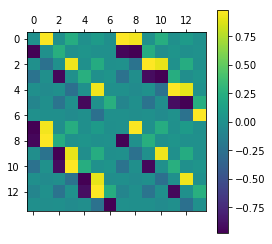

(0.98010297075348674-0.18526991921704294j)

In [59]:
import matplotlib.pyplot as plt
from PPFtfim import tfim

L=20
h=1
la1=0.5
M=np.zeros((L,L))
for i in range(L):
    M[i,i]=h
    
for i in range(L-1):
    M[i,i+1]=-la1

t1=tfim(M)

print(t1.correlator_dynamics(10,1,10)

S=t1.aux_pfaffian_constructor(4,4,0.1)
plt.matshow(S.real)
plt.colorbar()
plt.show()
pf(S)